In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from matplotlib import colormaps as cm
from rpy2.robjects import pandas2ri, r
import rpy2.robjects.packages as rpackages
from rpy2.robjects.packages import importr
import pbm
import geopandas as gpd
from shapely.geometry import Point
import math
from mpl_toolkits.axes_grid1 import make_axes_locatable
import kmapper as km
import pyballmapper as pbm
import statistics
import seaborn as sb
from matplotlib.colors import ListedColormap

from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patches as patches
import os



# UPLOAD WARDS DATA AND UK MAP

In [2]:
wards= pd.read_csv('generated_df/ward_codes.csv') 

In [3]:
#download the map of uk use in the census 2021
uk_shape = gpd.read_file('input_data/Wards_December_2022/WD_DEC_2022_UK_BFE.shp')

In [4]:
uk_shape = uk_shape[uk_shape['WD22CD'].str.startswith(('E'))]#only use England data
uk_shape = uk_shape.rename(columns={'WD22NM': 'ward'})
uk_shape = uk_shape.rename(columns={'WD22CD': 'wardcode'})
uk_shape = uk_shape.rename(columns={'LAD22NM': 'Local_Authority_D'})

# UPLOAD FINAL DATAFRAME

In [5]:
#df with dummies
dfWD= pd.read_csv('generated_df/dfWD.csv') 

In [6]:
#df without dummies
df= pd.read_csv('generated_df/dfwod.csv') 

In [7]:
df.set_index([df.columns[0], df.columns[1],df.columns[2]], inplace=True)


In [8]:
df

,,,pop_density_sqrkilometer,Pborn_Europe,total_population,Ptotal_populationF,Ptotal_populationM,PEconomicallyInactive,Pwhite,Pother_ethnic,Phousehold_notdeprived,Phousehold_deprived1D,...,Presi_L3toL4quali,PL1toL9_NS,PL10toL11_7_NS,PL12to13NS,PL14to15NS,air_score_ward,GP_unique_name_count,PH_unique_name_count,Uni_score_ward,PriS_unique_name_count
wardcode,ward,Local_Authority_D,,,,,,,,,,,,,,,,,,,,,
E05013038,Burn Valley,Hartlepool,2895.6,97.1,7631,51.3,48.7,48.6,94.8,5.2,40.5,33.2,...,45.1,30.8,16.8,27.8,24.6,0,12.0,3.0,0,4.0
E05013039,De Bruce,Hartlepool,2722.9,98.4,8055,52.4,47.6,49.2,97.5,2.5,35.6,33.3,...,35.1,22.2,16.4,37.3,24.0,0,12.0,2.0,0,3.0
E05013040,Fens & Greatham,Hartlepool,331.5,98.8,6380,52.1,47.9,47.3,98.8,1.3,46.9,36.1,...,44.2,35.9,21.3,28.2,14.6,0,1.0,2.0,0,3.0
E05013041,Foggy Furze,Hartlepool,4832.0,97.2,8154,51.3,48.7,48.4,96.2,3.8,39.1,34.5,...,38.2,26.8,17.6,34.7,20.8,0,2.0,2.0,0,3.0
E05013042,Hart,Hartlepool,676.0,98.9,7644,51.8,48.2,34.1,98.2,1.8,55.7,30.6,...,54.7,43.2,20.2,23.6,13.0,0,0.0,1.0,0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
E05014383,Taunton North,Somerset West and Taunton,3095.5,96.7,10497,50.9,49.1,36.0,95.1,4.8,46.1,34.1,...,43.3,36.3,20.0,32.9,10.7,0,2.0,2.0,0,3.0
E05014384,Taunton South,Somerset West and Taunton,3187.8,95.4,11284,52.0,48.0,38.9,94.7,5.2,50.8,32.5,...,47.4,40.7,19.5,28.1,11.8,0,3.0,2.0,0,3.0
E05014385,Upper Tone,Somerset West and Taunton,64.5,96.8,9413,51.1,48.9,43.7,98.2,1.9,54.9,33.9,...,55.4,58.4,15.0,17.2,9.4,0,1.0,1.0,0,6.0


# Kmeans

In [9]:
dfkmeans = df.copy()

In [10]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(dfkmeans)


In [11]:
X_scaled_df1 = pd.DataFrame(X_scaled, index=df.index, columns=df.columns)

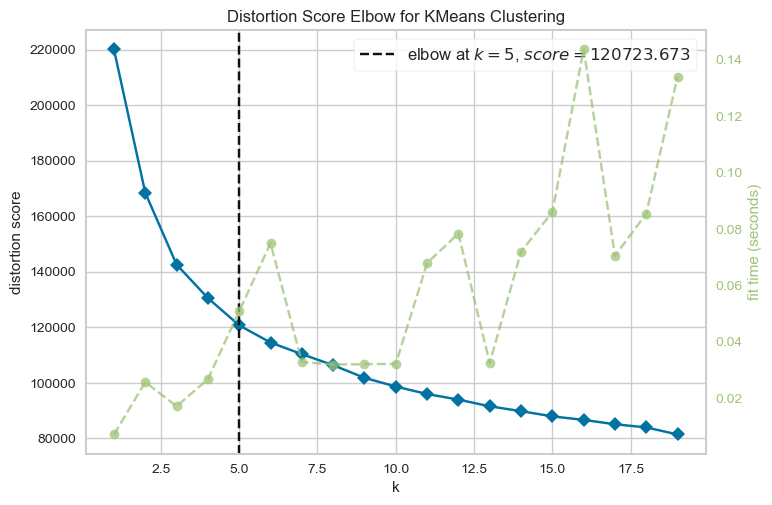

Average Silhouette Score for k=5: 0.1490
Davies-Bouldin Score for k=5: 1.7713
Calinski-Harabasz Score for k=5: 1413.0390


In [12]:



lowest_inertia = float('inf')
best_k = 0
best_model = None

for k in range(1, 21):  
    for random_state in range(0, 10):  
        model = KMeans(n_clusters=k, random_state=random_state)
        model.fit(X_scaled)
        inertia = model.inertia_
        
        if inertia < lowest_inertia:
            lowest_inertia = inertia
            best_k = k
            best_model = model  


visualizer = KElbowVisualizer(best_model, k=(1, 20))
visualizer.fit(X_scaled)
visualizer.show()


best_k = visualizer.elbow_value_

kmeans = KMeans(n_clusters=best_k, random_state=42)
dfkmeans['cluster'] = kmeans.fit_predict(X_scaled)

avg_silhouette_score = silhouette_score(X_scaled, dfkmeans['cluster'])
print(f'Average Silhouette Score for k={best_k}: {avg_silhouette_score:.4f}')

davies_bouldin = davies_bouldin_score(X_scaled, dfkmeans['cluster'])
print(f'Davies-Bouldin Score for k={best_k}: {davies_bouldin:.4f}')

calinski_harabasz = calinski_harabasz_score(X_scaled, dfkmeans['cluster'])
print(f'Calinski-Harabasz Score for k={best_k}: {calinski_harabasz:.4f}')

visualizer.ax.figure.savefig('generated_df/Kmeansclusters_figures/elbow_plot5.png', dpi=300)



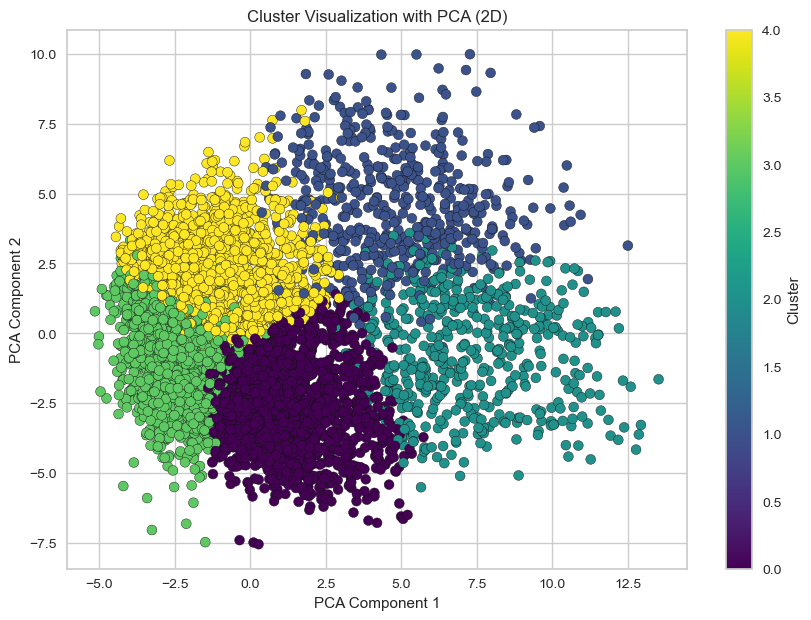

In [13]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(10, 7))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=dfkmeans['cluster'], cmap='viridis', marker='o', edgecolor='k', s=50)
plt.title('Cluster Visualization with PCA (2D)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.savefig('generated_df/Kmeansclusters_figures/pca_plot5clusters.png', dpi=300)
plt.show()

In [14]:
dfkmeans['cluster5'] = dfkmeans['cluster']
dfkmeans.drop(columns=['cluster'], inplace=True)


In [15]:
dfkmeans.head()

,,,pop_density_sqrkilometer,Pborn_Europe,total_population,Ptotal_populationF,Ptotal_populationM,PEconomicallyInactive,Pwhite,Pother_ethnic,Phousehold_notdeprived,Phousehold_deprived1D,...,PL1toL9_NS,PL10toL11_7_NS,PL12to13NS,PL14to15NS,air_score_ward,GP_unique_name_count,PH_unique_name_count,Uni_score_ward,PriS_unique_name_count,cluster5
wardcode,ward,Local_Authority_D,,,,,,,,,,,,,,,,,,,,,
E05013038,Burn Valley,Hartlepool,2895.6,97.1,7631,51.3,48.7,48.6,94.8,5.2,40.5,33.2,...,30.8,16.8,27.8,24.6,0,12.0,3.0,0,4.0,0
E05013039,De Bruce,Hartlepool,2722.9,98.4,8055,52.4,47.6,49.2,97.5,2.5,35.6,33.3,...,22.2,16.4,37.3,24.0,0,12.0,2.0,0,3.0,0
E05013040,Fens & Greatham,Hartlepool,331.5,98.8,6380,52.1,47.9,47.3,98.8,1.3,46.9,36.1,...,35.9,21.3,28.2,14.6,0,1.0,2.0,0,3.0,3
E05013041,Foggy Furze,Hartlepool,4832.0,97.2,8154,51.3,48.7,48.4,96.2,3.8,39.1,34.5,...,26.8,17.6,34.7,20.8,0,2.0,2.0,0,3.0,0
E05013042,Hart,Hartlepool,676.0,98.9,7644,51.8,48.2,34.1,98.2,1.8,55.7,30.6,...,43.2,20.2,23.6,13.0,0,0.0,1.0,0,2.0,4


In [16]:
dfkmeans.to_csv('generated_df/kmenascluster_tables/dfkmeans5clusters.csv', index=True)

In [17]:
dfkmeans= pd.read_csv('generated_df/kmenascluster_tables/dfkmeans5clusters.csv') 

In [18]:
dfWD['cluster5'] = dfkmeans['cluster5']


In [19]:
dfWD.head()

,wardcode,ward,Local_Authority_D,pop_density_sqrkilometer,Pborn_Europe,total_population,Ptotal_populationF,Ptotal_populationM,PEconomicallyInactive,Pwhite,...,PriS_unique_name_count,small_communities,rural_communites,majorityL3L4q,majorityP16to49_age,dnone50,GP_above1,VeryGoodhealth,PH_above1,cluster5
0,E05013038,Burn Valley,Hartlepool,2895.6,97.1,7631,51.3,48.7,48.6,94.8,...,4.0,0,0,0,0,0,1,0,1,0
1,E05013039,De Bruce,Hartlepool,2722.9,98.4,8055,52.4,47.6,49.2,97.5,...,3.0,0,0,0,0,0,1,0,1,0
2,E05013040,Fens & Greatham,Hartlepool,331.5,98.8,6380,52.1,47.9,47.3,98.8,...,3.0,0,0,0,0,0,1,0,1,3
3,E05013041,Foggy Furze,Hartlepool,4832.0,97.2,8154,51.3,48.7,48.4,96.2,...,3.0,0,0,0,0,0,1,0,1,0
4,E05013042,Hart,Hartlepool,676.0,98.9,7644,51.8,48.2,34.1,98.2,...,2.0,0,0,1,0,1,0,1,1,4


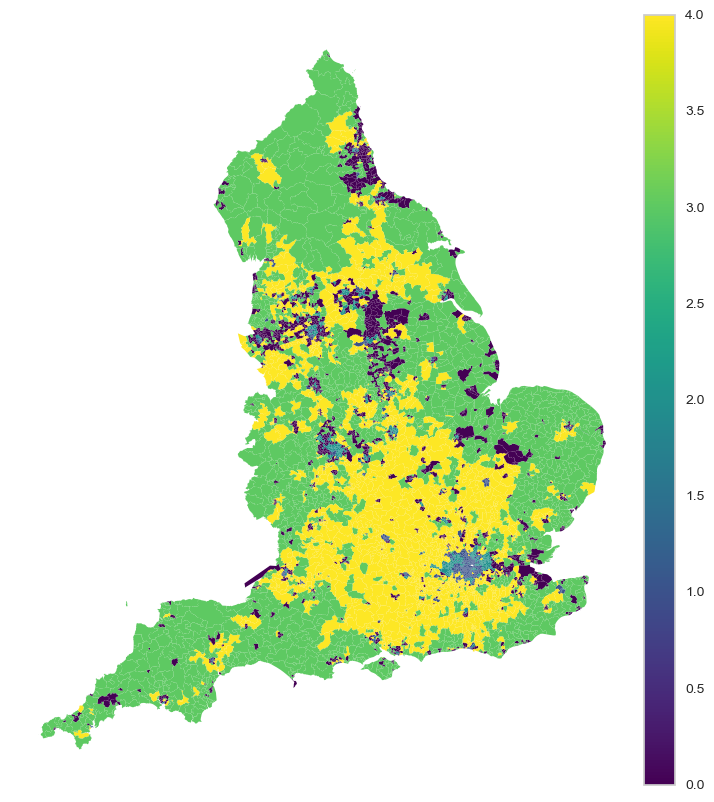

In [20]:
merge_u = uk_shape.merge(dfkmeans, on=['wardcode'])

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.set_axis_off()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
merge_u.plot(column="cluster5", ax=ax, legend=True, cax=cax, cmap='viridis', vmin=0, vmax=4)
plt.show()

Original Bounds: minx=332390.20210000034, maxx=390350.2030999996, miny=379748.4975000005, maxy=405357.59699999914
Expanded and Adjusted Bounds: minx=303410.2016000007, maxx=419330.2035999992, miny=341334.8482500026, maxy=443771.24624999706


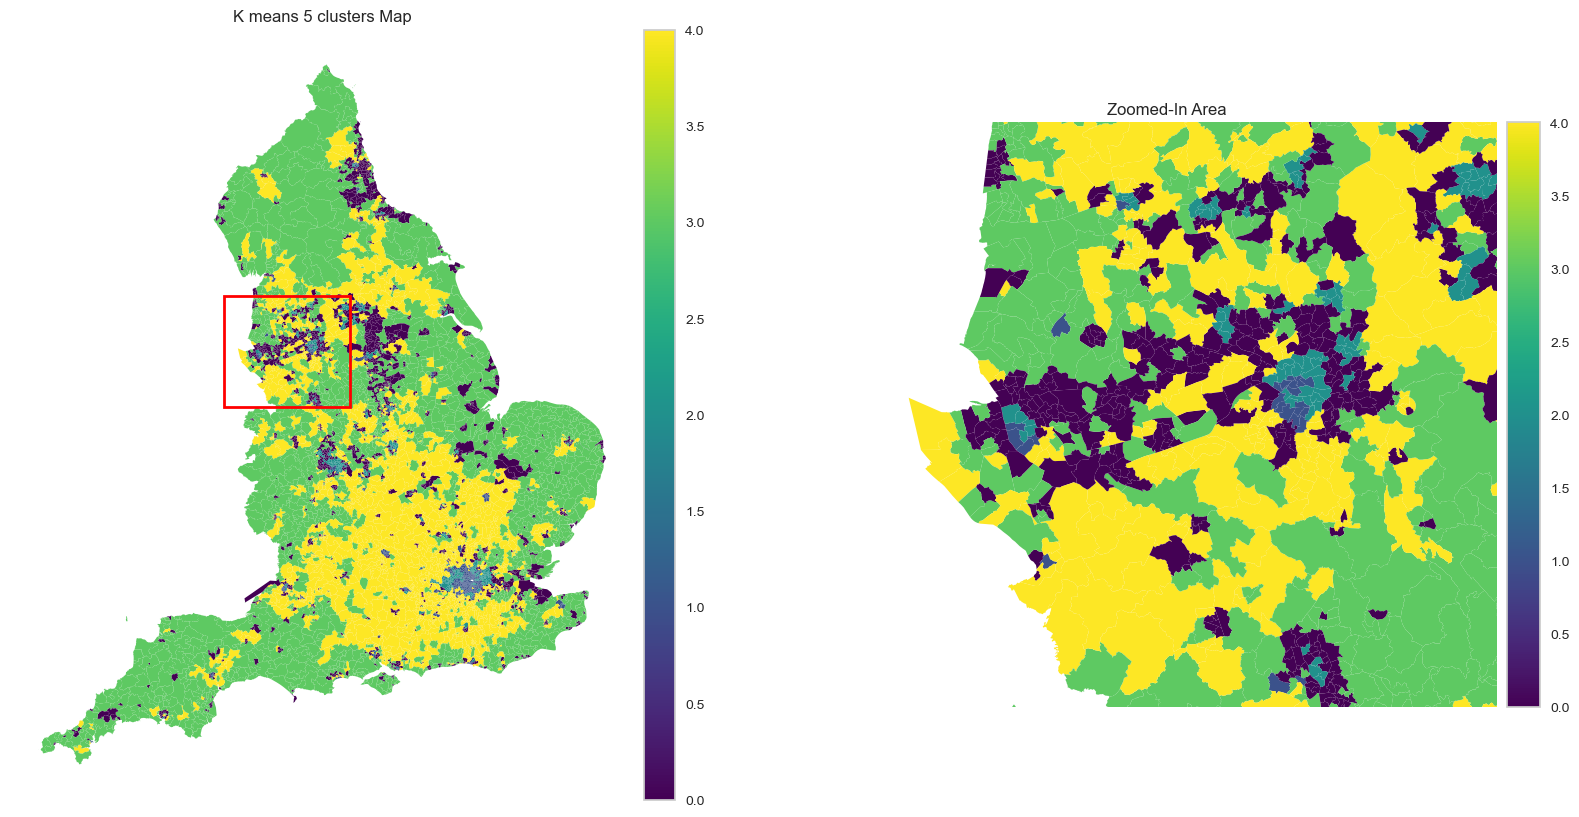

In [21]:

wards_of_interest = [
     'Liverpool', 'Manchester'
]

filtered_merge_u = merge_u[merge_u['Local_Authority_D_x'].isin(wards_of_interest)]  # Replace 'wardname' with the correct column name if different


if filtered_merge_u.empty:
    print("No data found for the specified wards.")
else:
    minx, miny, maxx, maxy = filtered_merge_u.total_bounds

    print(f"Original Bounds: minx={minx}, maxx={maxx}, miny={miny}, maxy={maxy}")

    width = maxx - minx
    height = maxy - miny

    expanded_width = width * 2
    expanded_height = height * 4

    center_x = (minx + maxx) / 2
    center_y = (miny + maxy) / 2

    new_minx = center_x - expanded_width / 2
    new_maxx = center_x + expanded_width / 2
    new_miny = (center_y - expanded_height / 2) #+ north_offset  # Apply northward offset
    new_maxy = (center_y + expanded_height / 2) #+ north_offset  # Apply northward offset

    print(f"Expanded and Adjusted Bounds: minx={new_minx}, maxx={new_maxx}, miny={new_miny}, maxy={new_maxy}")

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

    ax1.set_title("K means 5 clusters Map")
    ax1.set_axis_off()
    divider1 = make_axes_locatable(ax1)
    cax1 = divider1.append_axes("right", size="5%", pad=0.1)
    merge_u.plot(column="cluster5", ax=ax1, legend=True, cax=cax1, cmap='viridis', vmin=0, vmax=4)

    rect = patches.Rectangle((new_minx, new_miny), expanded_width, expanded_height, linewidth=2, edgecolor='red', facecolor='none')
    ax1.add_patch(rect)

    ax2.set_title("Zoomed-In Area")
    ax2.set_axis_off()
    divider2 = make_axes_locatable(ax2)
    cax2 = divider2.append_axes("right", size="5%", pad=0.1)
    merge_u.plot(column="cluster5", ax=ax2, legend=True, cax=cax2, cmap='viridis', vmin=0, vmax=4)

    ax2.set_xlim(new_minx, new_maxx)
    ax2.set_ylim(new_miny, new_maxy)
    

    plt.savefig('generated_df/Kmeansclusters_figures/K_means_5clusters_Map.png', dpi=300)


    plt.show()


In [25]:
zoomed_in_data = filtered_merge_u.cx[new_minx:new_maxx, new_miny:new_maxy]

zoomed_in_csv = zoomed_in_data[['ward_x','Local_Authority_D_x', 'cluster5']]

zoomed_in_csv.to_csv('generated_df/kmenascluster_tables/zoomed_in_wards_clusters.csv', index=False)


In [26]:
zoomed_in_csv.describe()

,cluster5
count,62.000000
mean,1.258065
std,1.186474
min,0.000000
25%,0.000000
50%,1.000000
75%,2.000000
max,4.000000


# join clusters

join scaled df with the number of clusters

In [30]:
df_clusters= X_scaled_df1.reset_index()

In [31]:
df_clusters[['small_communities', 'rural_communites','majorityL3L4q','majorityP16to49_age','dnone50','GP_above1','VeryGoodhealth','PH_above1']] = dfWD[['small_communities', 'rural_communites','majorityL3L4q','majorityP16to49_age','dnone50','GP_above1','VeryGoodhealth','PH_above1']]


In [32]:
df_clusters['cluster5'] = dfkmeans['cluster5']
df_clusters

,wardcode,ward,Local_Authority_D,pop_density_sqrkilometer,Pborn_Europe,total_population,Ptotal_populationF,Ptotal_populationM,PEconomicallyInactive,Pwhite,...,PriS_unique_name_count,small_communities,rural_communites,majorityL3L4q,majorityP16to49_age,dnone50,GP_above1,VeryGoodhealth,PH_above1,cluster5
0,E05013038,Burn Valley,Hartlepool,0.068075,0.563326,-0.123780,0.165709,-0.165699,1.373991,0.491627,...,1.040543,0,0,0,0,0,1,0,1,0
1,E05013039,De Bruce,Hartlepool,0.011814,0.714817,-0.030062,0.942356,-0.942347,1.466255,0.649784,...,0.458097,0,0,0,0,0,1,0,1,0
2,E05013040,Fens & Greatham,Hartlepool,-0.767240,0.761429,-0.400292,0.730543,-0.730534,1.174087,0.725933,...,0.458097,0,0,0,0,0,1,0,1,3
3,E05013041,Foggy Furze,Hartlepool,0.698903,0.574979,-0.008180,0.165709,-0.165699,1.343237,0.573634,...,0.458097,0,0,0,0,0,1,0,1,0
4,E05013042,Hart,Hartlepool,-0.655011,0.773083,-0.120907,0.518730,-0.518721,-0.855709,0.690787,...,-0.124350,0,0,1,0,1,0,1,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6871,E05014383,Taunton North,Somerset West and Taunton,0.133198,0.516713,0.509699,-0.116709,0.116719,-0.563542,0.509200,...,0.458097,0,0,0,0,0,1,0,1,0
6872,E05014384,Taunton South,Somerset West and Taunton,0.163266,0.365222,0.683652,0.659938,-0.659930,-0.117601,0.485769,...,0.458097,0,0,0,0,1,1,0,1,0
6873,E05014385,Upper Tone,Somerset West and Taunton,-0.854222,0.528366,0.270100,0.024500,-0.024490,0.620506,0.690787,...,2.205437,0,1,1,0,1,1,0,1,3
6874,E05014386,Watchet & Stogursey,Somerset West and Taunton,-0.838617,0.633245,0.319390,0.518730,-0.518721,1.650782,0.702502,...,0.458097,0,1,0,0,0,1,0,1,3


In [33]:
csv_file_path = 'generated_df/kmenascluster_tables/kmeans_clusters_df.csv'
df_clusters.to_csv(csv_file_path, index=True)

# AUXILIAR CALCULATIONS relevant for the overall understanding but not explicit in the ERP

# PARTICIPATION

In [34]:
result = {}

total_wards_per_cluster = df_clusters.groupby('cluster5').size()

for column in ['small_communities', 'rural_communites', 'majorityL3L4q', 
                'majorityP16to49_age', 'dnone50', 'GP_above1', 
                'VeryGoodhealth', 'PH_above1']:
    
    positive_counts = df_clusters.groupby('cluster5')[column].apply(lambda x: (x > 0).sum())
    
    percentages = (positive_counts / total_wards_per_cluster) * 100
    
    result[column] = percentages

result_df1 = pd.DataFrame(result).fillna(0)

size = df_clusters['cluster5'].value_counts()

result_df1['size'] = size

result_df1

,small_communities,rural_communites,majorityL3L4q,majorityP16to49_age,dnone50,GP_above1,VeryGoodhealth,PH_above1,size
cluster5,,,,,,,,,
0,12.693854,3.216542,4.422746,4.595060,3.273980,61.631246,2.584721,74.956921,1741
1,0.781250,0.195312,100.000000,82.226562,64.062500,69.140625,88.671875,73.242188,512
2,0.590551,0.000000,37.795276,52.559055,1.377953,76.968504,40.157480,82.480315,508
3,44.791189,48.279027,38.687471,0.091785,54.474530,45.112437,9.270307,50.894906,2179
4,26.549587,31.508264,91.167355,4.287190,97.365702,51.033058,77.427686,57.747934,1936


# PERFORMANCE

In [35]:
index_labels = list(range(5))
df = pd.DataFrame(result_df1, index=index_labels)


df

,small_communities,rural_communites,majorityL3L4q,majorityP16to49_age,dnone50,GP_above1,VeryGoodhealth,PH_above1,size
0,12.693854,3.216542,4.422746,4.595060,3.273980,61.631246,2.584721,74.956921,1741
1,0.781250,0.195312,100.000000,82.226562,64.062500,69.140625,88.671875,73.242188,512
2,0.590551,0.000000,37.795276,52.559055,1.377953,76.968504,40.157480,82.480315,508
3,44.791189,48.279027,38.687471,0.091785,54.474530,45.112437,9.270307,50.894906,2179
4,26.549587,31.508264,91.167355,4.287190,97.365702,51.033058,77.427686,57.747934,1936


In [36]:
columns_to_include = df.columns.difference(['small_communities', 'rural_communites','size'])

df['performance_score'] = df[columns_to_include].mean(axis=1)


df

,small_communities,rural_communites,majorityL3L4q,majorityP16to49_age,dnone50,GP_above1,VeryGoodhealth,PH_above1,size,performance_score
0,12.693854,3.216542,4.422746,4.595060,3.273980,61.631246,2.584721,74.956921,1741,25.244113
1,0.781250,0.195312,100.000000,82.226562,64.062500,69.140625,88.671875,73.242188,512,79.557292
2,0.590551,0.000000,37.795276,52.559055,1.377953,76.968504,40.157480,82.480315,508,48.556430
3,44.791189,48.279027,38.687471,0.091785,54.474530,45.112437,9.270307,50.894906,2179,33.088573
4,26.549587,31.508264,91.167355,4.287190,97.365702,51.033058,77.427686,57.747934,1936,63.171488


In [37]:
df_ranked = df.sort_values(by='performance_score', ascending=False)

df_ranked

,small_communities,rural_communites,majorityL3L4q,majorityP16to49_age,dnone50,GP_above1,VeryGoodhealth,PH_above1,size,performance_score
1,0.781250,0.195312,100.000000,82.226562,64.062500,69.140625,88.671875,73.242188,512,79.557292
4,26.549587,31.508264,91.167355,4.287190,97.365702,51.033058,77.427686,57.747934,1936,63.171488
2,0.590551,0.000000,37.795276,52.559055,1.377953,76.968504,40.157480,82.480315,508,48.556430
3,44.791189,48.279027,38.687471,0.091785,54.474530,45.112437,9.270307,50.894906,2179,33.088573
0,12.693854,3.216542,4.422746,4.595060,3.273980,61.631246,2.584721,74.956921,1741,25.244113


# MEAN NOT STANDARIZED

In [38]:
columns = [
    'pop_density_sqrkilometer','Pborn_Europe', 'total_population', 'Ptotal_populationF', 'Ptotal_populationM', 
    'PEconomicallyInactive', 'Pwhite', 'Pother_ethnic', 'Phousehold_notdeprived', 
    'Phousehold_deprived1D', 'PhouseOwned', 'PhouseSocialRented', 'PhousePrivateRented', 
    'P0to15_age', 'P16to49_age', 'P50over_age', 'Pborn_outsideEurope', 'Pinemployment', 
    'Punemployment', 'Phousehold_D2ormore', 'Presi_0toL1quali', 'Presi_L2toApprequali', 
    'Presi_L3toL4quali', 'PL1toL9_NS', 'PL10toL11_7_NS', 'PL12to13NS', 'PL14to15NS', 
    'air_score_ward', 'GP_unique_name_count', 'PH_unique_name_count', 'Uni_score_ward', 
    'PriS_unique_name_count','small_communities', 'rural_communites', 'majorityL3L4q', 
                'majorityP16to49_age', 'dnone50', 'GP_above1', 
                'VeryGoodhealth', 'PH_above1'
]


means = {}

for col in columns:
    means[col] = dfWD.groupby('cluster5')[col].mean()

k_meansmean_df = pd.DataFrame(means)

size = dfkmeans['cluster5'].value_counts()

k_meansmean_df['size'] = size

k_meansmean_df_transposed = k_meansmean_df.T
k_meansmean_df_transposed

cluster5,0,1,2,3,4
pop_density_sqrkilometer,3052.993452,8300.136133,7032.618307,994.970353,1636.238068
Pborn_Europe,94.686157,78.849219,72.423228,97.205737,93.284401
total_population,9231.431361,12096.865234,14775.566929,5519.663607,7501.300620
Ptotal_populationF,51.014877,51.198633,50.432677,51.321661,50.952841
Ptotal_populationM,48.985123,48.801172,49.567323,48.678339,49.047159
PEconomicallyInactive,39.725503,35.321484,39.782480,43.918311,35.940496
Pwhite,89.569730,66.074414,42.325787,96.308490,89.362862
Pother_ethnic,10.425273,33.922852,57.673622,3.687242,10.634401
Phousehold_notdeprived,42.000804,53.069336,37.623425,50.232308,57.811725
Phousehold_deprived1D,34.801206,31.005664,36.148228,34.747086,30.793802


In [40]:
csv_file_path = 'generated_df/kmenascluster_tables/k_means5mean_dfnotsd.csv'
k_meansmean_df_transposed.to_csv(csv_file_path, index=True)

In [41]:
result = {}

total_wards_per_cluster = dfWD.groupby('cluster5').size()

for column in ['small_communities', 'rural_communites', 'majorityL3L4q', 
                'majorityP16to49_age', 'dnone50', 'GP_above1', 
                'VeryGoodhealth', 'PH_above1']:
    
    positive_counts = dfWD.groupby('cluster5')[column].apply(lambda x: (x > 0).sum())
    
    percentages = (positive_counts / total_wards_per_cluster) * 100
    
    result[column] = percentages

result_df = pd.DataFrame(result).fillna(0)

size = dfWD['cluster5'].value_counts()

result_df['size'] = size

result_df_transposed = result_df.T
result_df_transposed

cluster5,0,1,2,3,4
small_communities,12.693854,0.781250,0.590551,44.791189,26.549587
rural_communites,3.216542,0.195312,0.000000,48.279027,31.508264
majorityL3L4q,4.422746,100.000000,37.795276,38.687471,91.167355
majorityP16to49_age,4.595060,82.226562,52.559055,0.091785,4.287190
dnone50,3.273980,64.062500,1.377953,54.474530,97.365702
GP_above1,61.631246,69.140625,76.968504,45.112437,51.033058
VeryGoodhealth,2.584721,88.671875,40.157480,9.270307,77.427686
PH_above1,74.956921,73.242188,82.480315,50.894906,57.747934
size,1741.000000,512.000000,508.000000,2179.000000,1936.000000


In [42]:
latex_code = result_df_transposed.to_latex(index=True, caption='Percentage of Wards with Positive Dummy Variables by Cluster', label='tab:dummy_variable_percentages')

output_folder = 'generated_df/kmenascluster_tables'
output_filename = os.path.join(output_folder, '5clustersdummy_variable_percentages.tex')

os.makedirs(output_folder, exist_ok=True)

with open(output_filename, 'w') as file:
    file.write(latex_code)

print(f"LaTeX table saved to {output_filename}")

LaTeX table saved to generated_df/kmenascluster_tables/5clustersdummy_variable_percentages.tex


/var/folders/r0/53lbrfvx4kd2t6dzcz18qbhr0000gn/T/ipykernel_25669/2808520173.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_code = result_df_transposed.to_latex(index=True, caption='Percentage of Wards with Positive Dummy Variables by Cluster', label='tab:dummy_variable_percentages')


# SD NOT STANDARIZED

In [43]:
columns = [
    'pop_density_sqrkilometer','Pborn_Europe', 'total_population', 'Ptotal_populationF', 'Ptotal_populationM', 
    'PEconomicallyInactive', 'Pwhite', 'Pother_ethnic', 'Phousehold_notdeprived', 
    'Phousehold_deprived1D', 'PhouseOwned', 'PhouseSocialRented', 'PhousePrivateRented', 
    'P0to15_age', 'P16to49_age', 'P50over_age', 'Pborn_outsideEurope', 'Pinemployment', 
    'Punemployment', 'Phousehold_D2ormore', 'Presi_0toL1quali', 'Presi_L2toApprequali', 
    'Presi_L3toL4quali', 'PL1toL9_NS', 'PL10toL11_7_NS', 'PL12to13NS', 'PL14to15NS', 
    'air_score_ward', 'GP_unique_name_count', 'PH_unique_name_count', 'Uni_score_ward', 
    'PriS_unique_name_count'
]

# Dictionary to store standard deviation values
std = {}

# Compute the standard deviation for each column
for col in columns:
    std[col] = dfkmeans.groupby('cluster5')[col].std()

# Convert this dictionary to a DataFrame
k_meansstd_df = pd.DataFrame(std)

k_meansstd_df_transposed = k_meansstd_df.T
k_meansstd_df_transposed

cluster5,0,1,2,3,4
pop_density_sqrkilometer,1767.647158,4336.957111,3620.880290,1237.962640,1673.939107
Pborn_Europe,4.226457,7.396059,9.668206,1.551234,4.380082
total_population,4140.052308,3938.569077,4155.533002,2841.788538,3834.854748
Ptotal_populationF,1.285124,1.965908,1.513006,1.315622,1.369646
Ptotal_populationM,1.285124,1.965863,1.513006,1.315622,1.369646
PEconomicallyInactive,4.801534,10.350606,6.348578,4.897377,4.944535
Pwhite,9.049164,13.110205,17.219608,2.964914,9.019608
Pother_ethnic,9.050332,13.111005,17.219424,2.967062,9.022900
Phousehold_notdeprived,5.080153,6.668172,5.820238,4.618790,4.134579
Phousehold_deprived1D,1.684846,2.761163,1.869198,2.092403,1.987143


In [44]:
csv_file_path = 'generated_df/k_meanscorr_df.csv'
k_meansstd_df_transposed.to_csv(csv_file_path, index=True)

In [45]:
k_meansstd_df_transposed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32 entries, pop_density_sqrkilometer to PriS_unique_name_count
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       32 non-null     float64
 1   1       32 non-null     float64
 2   2       32 non-null     float64
 3   3       32 non-null     float64
 4   4       32 non-null     float64
dtypes: float64(5)
memory usage: 1.5+ KB


In [46]:
column_means = k_meansstd_df_transposed.mean()

average_row = pd.DataFrame([column_means], columns=k_meansstd_df_transposed.columns)

k_meansstd_df_transposed_with_avg = pd.concat([k_meansstd_df_transposed, average_row], ignore_index=True)

k_meansstd_df_transposed_with_avg.index = list(k_meansstd_df_transposed.index) + ['Average']

k_meansstd_df_transposed_with_avg

cluster5,0,1,2,3,4
pop_density_sqrkilometer,1767.647158,4336.957111,3620.880290,1237.962640,1673.939107
Pborn_Europe,4.226457,7.396059,9.668206,1.551234,4.380082
total_population,4140.052308,3938.569077,4155.533002,2841.788538,3834.854748
Ptotal_populationF,1.285124,1.965908,1.513006,1.315622,1.369646
Ptotal_populationM,1.285124,1.965863,1.513006,1.315622,1.369646
PEconomicallyInactive,4.801534,10.350606,6.348578,4.897377,4.944535
Pwhite,9.049164,13.110205,17.219608,2.964914,9.019608
Pother_ethnic,9.050332,13.111005,17.219424,2.967062,9.022900
Phousehold_notdeprived,5.080153,6.668172,5.820238,4.618790,4.134579
Phousehold_deprived1D,1.684846,2.761163,1.869198,2.092403,1.987143


# PARTICIPATION

In [48]:
result = {}

total_wards_per_cluster = df_clusters.groupby('cluster5').size()

for column in ['small_communities', 'rural_communites', 'majorityL3L4q', 
                'majorityP16to49_age', 'dnone50', 'GP_above1', 
                'VeryGoodhealth', 'PH_above1']:
    
    positive_counts = df_clusters.groupby('cluster5')[column].apply(lambda x: (x > 0).sum())
    
    percentages = (positive_counts / total_wards_per_cluster) * 100
    
    result[column] = percentages

result_df = pd.DataFrame(result).fillna(0)

size = df_clusters['cluster5'].value_counts()

result_df['size'] = size

result_df

,small_communities,rural_communites,majorityL3L4q,majorityP16to49_age,dnone50,GP_above1,VeryGoodhealth,PH_above1,size
cluster5,,,,,,,,,
0,12.693854,3.216542,4.422746,4.595060,3.273980,61.631246,2.584721,74.956921,1741
1,0.781250,0.195312,100.000000,82.226562,64.062500,69.140625,88.671875,73.242188,512
2,0.590551,0.000000,37.795276,52.559055,1.377953,76.968504,40.157480,82.480315,508
3,44.791189,48.279027,38.687471,0.091785,54.474530,45.112437,9.270307,50.894906,2179
4,26.549587,31.508264,91.167355,4.287190,97.365702,51.033058,77.427686,57.747934,1936


# STANDARIZED DATA MEANS

In [49]:
means = {}

for col in columns:
    means[col] = df_clusters.groupby('cluster5')[col].mean()

k_meansmean_dfsd = pd.DataFrame(means)

size = df_clusters['cluster5'].value_counts()

k_meansmean_dfsd['size'] = size

k_meansmean_dfsd_transposed = k_meansmean_dfsd.T
k_meansmean_dfsd_transposed

cluster5,0,1,2,3,4
pop_density_sqrkilometer,0.119350,1.828730,1.415806,-0.551099,-0.342191
Pborn_Europe,0.282037,-1.563466,-2.312297,0.575647,0.118688
total_population,0.229967,0.863321,1.455402,-0.590454,-0.152448
Ptotal_populationF,-0.035601,0.094139,-0.446658,0.181002,-0.079401
Ptotal_populationM,0.035611,-0.094267,0.446670,-0.180992,0.079411
PEconomicallyInactive,0.009338,-0.667879,0.018100,0.654077,-0.572692
Pwhite,0.185256,-1.191018,-2.582129,0.579989,0.173138
Pother_ethnic,-0.185318,1.190959,2.582067,-0.579972,-0.173070
Phousehold_notdeprived,-0.909402,0.421861,-1.435889,0.080639,0.992250
Phousehold_deprived1D,0.469582,-0.871943,0.945684,0.450453,-0.946825


In [50]:
df_excluding_last = k_meansmean_dfsd_transposed.iloc[:-1]

last_9_rows = df_excluding_last.iloc[-9:]

column_means_last_9 = last_9_rows.mean()


new_row = pd.DataFrame([column_means_last_9], index=['average_of_dummy_variables'])

k_meansmean_dfsd_transposed = pd.concat([k_meansmean_dfsd_transposed, new_row])

k_meansmean_dfsd_transposed

cluster5,0,1,2,3,4
pop_density_sqrkilometer,0.119350,1.828730,1.415806,-0.551099,-0.342191
Pborn_Europe,0.282037,-1.563466,-2.312297,0.575647,0.118688
total_population,0.229967,0.863321,1.455402,-0.590454,-0.152448
Ptotal_populationF,-0.035601,0.094139,-0.446658,0.181002,-0.079401
Ptotal_populationM,0.035611,-0.094267,0.446670,-0.180992,0.079411
PEconomicallyInactive,0.009338,-0.667879,0.018100,0.654077,-0.572692
Pwhite,0.185256,-1.191018,-2.582129,0.579989,0.173138
Pother_ethnic,-0.185318,1.190959,2.582067,-0.579972,-0.173070
Phousehold_notdeprived,-0.909402,0.421861,-1.435889,0.080639,0.992250
Phousehold_deprived1D,0.469582,-0.871943,0.945684,0.450453,-0.946825


# SD STANDARIZED

In [51]:
std = {}

for col in columns:
    std[col] = df_clusters.groupby('cluster5')[col].std()
    
kmeans_std_df = pd.DataFrame(std)
kmeans_std_df

kmeans_std_df['size'] = size

kmeans_std_df_transposed = kmeans_std_df.T
kmeans_std_df_transposed

cluster5,0,1,2,3,4
pop_density_sqrkilometer,0.575852,1.412865,1.179587,0.403295,0.545325
Pborn_Europe,0.492516,0.861874,1.126651,0.180768,0.510418
total_population,0.915086,0.870552,0.918508,0.628128,0.847628
Ptotal_populationF,0.907352,1.388015,1.068247,0.928886,0.967029
Ptotal_populationM,0.907354,1.387986,1.068249,0.928888,0.967031
PEconomicallyInactive,0.738344,1.591638,0.976236,0.753082,0.760333
Pwhite,0.530068,0.767950,1.008665,0.173674,0.528337
Pother_ethnic,0.530087,0.767925,1.008560,0.173784,0.528481
Phousehold_notdeprived,0.611013,0.802011,0.700027,0.555523,0.497285
Phousehold_deprived1D,0.595505,0.975926,0.660663,0.739554,0.702351


In [52]:
df_excluding_last = kmeans_std_df_transposed.iloc[:-1]

last_9_rows = df_excluding_last.iloc[-9:]

column_means_last_9 = last_9_rows.mean()


new_row = pd.DataFrame([column_means_last_9], index=['average_of_dummy_variables'])

kmeans_std_df_transposed = pd.concat([kmeans_std_df_transposed, new_row])
kmeans_std_df = kmeans_std_df_transposed.T

In [53]:
kmeans_std_df_transposed

cluster5,0,1,2,3,4
pop_density_sqrkilometer,0.575852,1.412865,1.179587,0.403295,0.545325
Pborn_Europe,0.492516,0.861874,1.126651,0.180768,0.510418
total_population,0.915086,0.870552,0.918508,0.628128,0.847628
Ptotal_populationF,0.907352,1.388015,1.068247,0.928886,0.967029
Ptotal_populationM,0.907354,1.387986,1.068249,0.928888,0.967031
PEconomicallyInactive,0.738344,1.591638,0.976236,0.753082,0.760333
Pwhite,0.530068,0.767950,1.008665,0.173674,0.528337
Pother_ethnic,0.530087,0.767925,1.008560,0.173784,0.528481
Phousehold_notdeprived,0.611013,0.802011,0.700027,0.555523,0.497285
Phousehold_deprived1D,0.595505,0.975926,0.660663,0.739554,0.702351


Information used for table 1

In [70]:
kmeans_std_df['average_of_dummy_variables'].describe()

count    5.000000
mean     0.899096
std      0.215178
min      0.665276
25%      0.754565
50%      0.822360
75%      1.116521
max      1.136758
Name: average_of_dummy_variables, dtype: float64

In [54]:
csv_file_path = 'generated_df/kmenascluster_tables/kmeans_std_df_transposed.csv'
kmeans_std_df_transposed.to_csv(csv_file_path, index=True)

In [55]:
latex_code = kmeans_std_df_transposed.to_latex(index=True, caption='Kmeans nodes standar deviation with standarized data', label='tab:tdabm_std_standardata')

output_folder = 'generated_df/kmenascluster_tables'
output_filename = os.path.join(output_folder, 'kmeans_std_standardata.tex')

os.makedirs(output_folder, exist_ok=True)

with open(output_filename, 'w') as file:
    file.write(latex_code)

print(f"LaTeX table saved to {output_filename}")

LaTeX table saved to generated_df/kmenascluster_tables/kmeans_std_standardata.tex


/var/folders/r0/53lbrfvx4kd2t6dzcz18qbhr0000gn/T/ipykernel_25669/3142176933.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_code = kmeans_std_df_transposed.to_latex(index=True, caption='Kmeans nodes standar deviation with standarized data', label='tab:tdabm_std_standardata')
